In [1]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# append sys.path
import pickle
import sys
sys.path.append('../src')

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

In [3]:
import matplotlib as mpl
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True

# remove all edges
mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams['axes.linewidth'] = 2

font = {'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)
cmap = ['tab:blue', 'tab:red', 'tab:orange', 'tab:purple', 'tab:green']

In [4]:
!pwd

/home/ubuntu/tmp/NSC/codes/notebook


## Interface for prior analysis

In [5]:
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
from simulator.DM_model import DM_model
from simulator.seqC_generator import seqC_generator
from simulator.model_sim_pR import get_boxUni_prior
from analysis.plot_sim_results import plot_parameters
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [6]:
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[11],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)


--- generated seqC info ---
dur_list: [11]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)


[ 0.          0.         -0.05022932 -0.09747953 -0.04146865 -0.08923845
 -0.03371636  0.01851269  0.06764402  0.06363203  0.00962866  0.00905758]


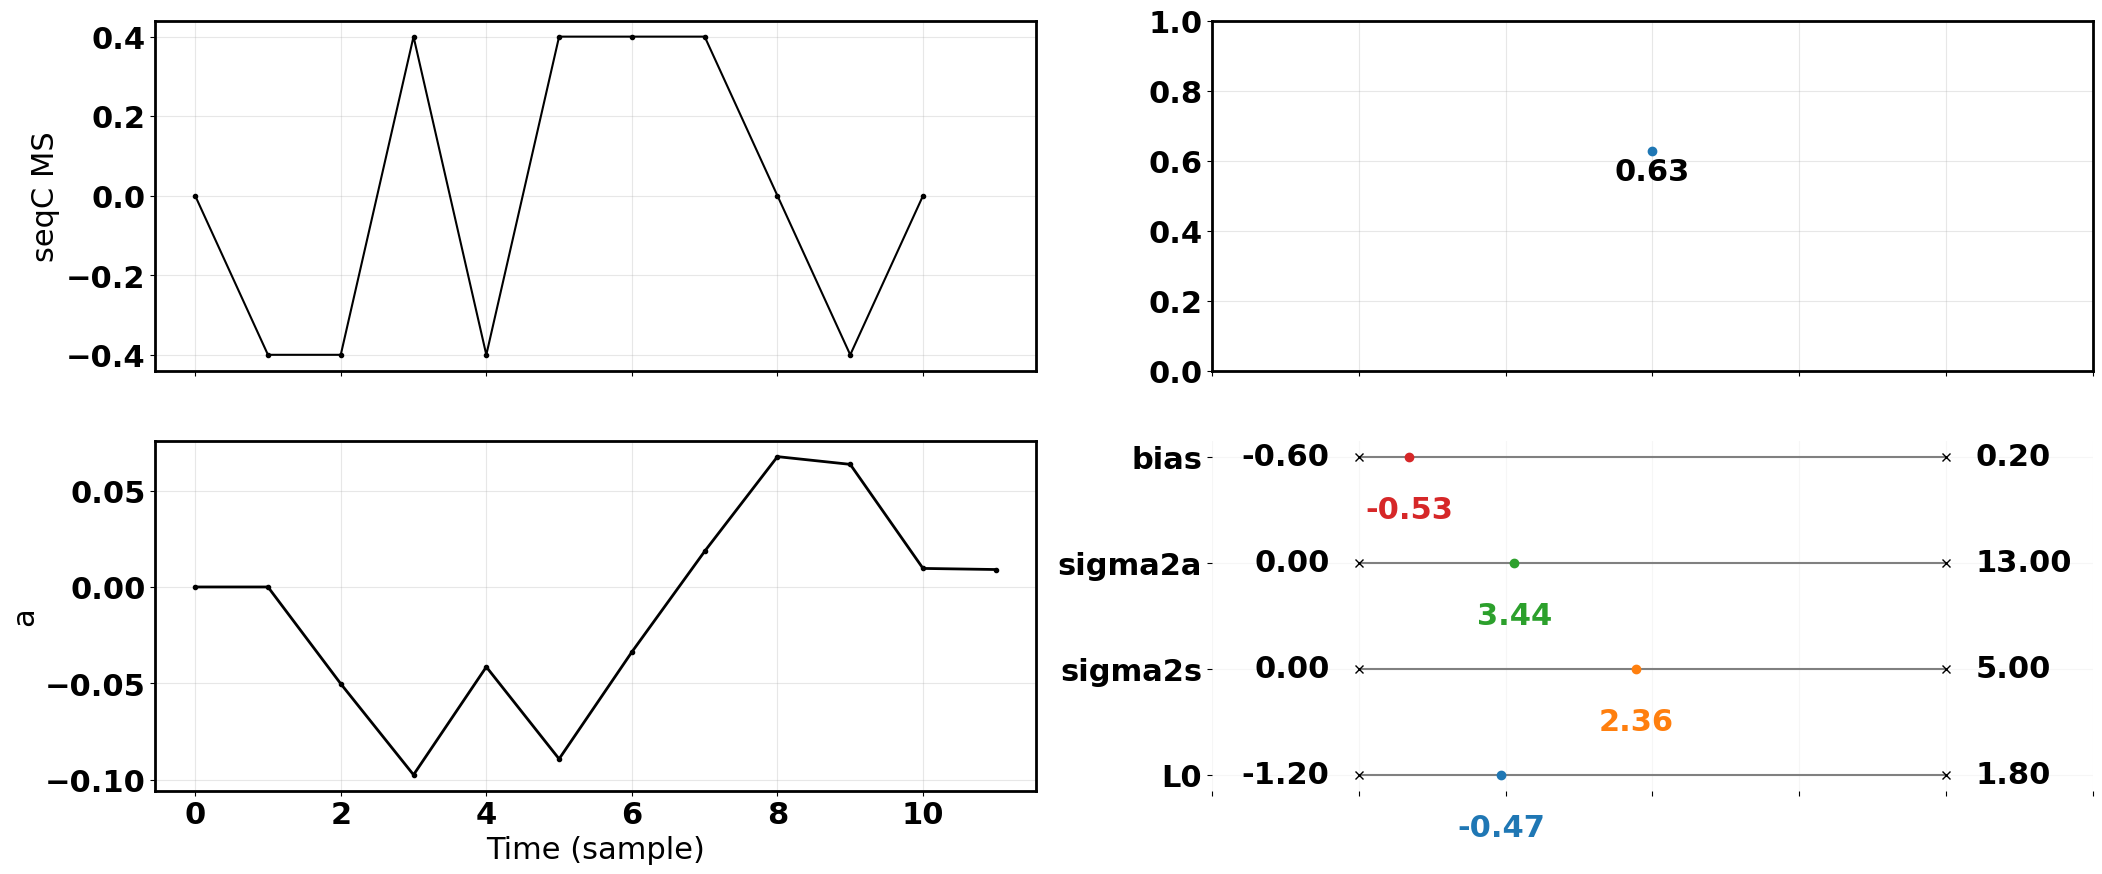

In [7]:
# generate prior parameters
model_name = 'B-G-L0S-O-N-'
prior_min = [-2.5,   0,  0, -11]
prior_max = [ 2.5,  77, 18,  10]
prior_min = [-0.6,   0,  0, -1.2]
prior_max = [ 0.2,  13,  5,  1.8]
prior = get_boxUni_prior(prior_min, prior_max)
params = prior.sample((1,))[0].tolist()

def plot_seqC_a_prior(model_name, prior_min, prior_max, params):
    
    model = DM_model(params=params, model_name=model_name)
    a, probR = model.simulate(seqC)
    print(a[::100])
    fig, axs = plt.subplots(2, 2, sharex='col', figsize=(25, 10))

    # plot input sequence
    ax = axs[0,0]
    ax.clear()
    ax.plot(seqC[0,0,0], '.-k')
    ax.grid(alpha=0.3)
    ax.set_ylabel('seqC MS')

    # plot a mean trace
    ax = axs[1,0]
    ax = model.plot_a_mean_trace(ax, a, color='k')
    
    # plot probR
    ax = axs[0,1]
    ax.clear()
    ax.plot(0, probR, 'o')
    if probR<0.5:
        ax.text(0, probR+0.1, f'{probR:.2f}', ha='center', va='top', color='k')
    else:
        ax.text(0, probR-0.1, f'{probR:.2f}', ha='center', va='bottom', color='k')
    ax.grid(alpha=0.3)
    ax.set_xlim(-1,1)
    ax.set_ylim(0,1)

    # plot parameter values
    ax = axs[1,1]
    prior_labels = ['bias', 'sigma2a', 'sigma2s', 'L0']
    plot_parameters(ax, params, prior_min, prior_max, prior_labels=prior_labels)

plot_seqC_a_prior(model_name, prior_min, prior_max, params)

## Sobol index (Sensitivity index)
measure of output variance contribution of each input parameter and its interaction with other input parameters

## correlation coefficient
measure of linear correlation between parameters
better not correlated

S1 contains the first-order sensitivity indices for each input variable. 
These indices represent the expected proportion of the variance of the output due to the input variable, assuming all other inputs are held constant. 
So the higher the index, the more sensitive the output is to that variable.
(S1_conf is the confidence interval of the sensitivity index S1)

ST contains the total-effect sensitivity indices for each input variable. 
These indices represent the expected proportion of the variance of the output due to the input variable and its interactions with other variables. 
This means that if ST is much larger than S1 for a particular variable, it indicates that interactions between this variable and others are important.

S2 contains the second-order sensitivity indices for each pair of input variables. These indices represent the expected proportion of the variance of the output due to the interaction between the two variables, assuming all other inputs are held constant.

In [67]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.stats import spearmanr
import numpy as np

def model(params):
    model = DM_model(params=params, model_name=model_name)
    a, probR = model.simulate(seqC)
    return probR


def compute_Si_corr(problem, nsample=2000):
    # generate samples
    param_values = saltelli.sample(problem, nsample)

    # calculate model output for the sampled parameter sets
    Y = np.zeros([param_values.shape[0]])
    for i, X in enumerate(param_values):
        Y[i] = model(X)

    # perform the sensitivity analysis
    Si = sobol.analyze(problem, Y, print_to_console=False)

    # print the first-order sensitivity indices
    # for name, s1 in zip(problem['names'], Si['S1']):
    #     print(f'Sensitivity index for {name}: {s1}')

    # calculate correlation among parameters
    corr, _ = spearmanr(param_values)
    # print('Spearman correlation: \n', corr)
    
    return Si, corr

def plot_Si(Si, problem):
    # plot the sensitivity indices
    fig, axs = plt.subplots(1, 3, figsize=(35, 8))
    ax = axs[0]
    ax.bar(problem['names'], Si['S1'], color='k')
    ax.set_ylabel('Sensitivity index')
    ax.set_ylim(0,1)
    ax.grid(alpha=0.3)

    ax = axs[1]
    ax.bar(problem['names'], Si['ST'], color='k')
    ax.set_ylabel('Total sensitivity index')
    ax.set_ylim(0,1)
    ax.grid(alpha=0.3)
    
    ax = axs[2]
    im = ax.imshow(Si['S2'], cmap='RdGy', vmin=-1, vmax=1)
    ax.set_xticks(np.arange(len(problem['names'])))
    ax.set_yticks(np.arange(len(problem['names'])))
    ax.set_xticklabels(problem['names'])
    ax.set_yticklabels(problem['names'])
    ax.set_title('S2 correlation')
    fig.colorbar(im, ax=ax)

In [ ]:
# define the problem
problem = {
    'num_vars': 4,
    'names': ['bias', 'sigma2a', 'sigma2s', 'L0'],
    'bounds': [[-0.6, 0.2],
               [   0,  13],
               [   0,   5],
               [-1.2, 1.8]],
    # 'bounds': [[-2.5, 2.5],
    #            [   0,  77],
    #            [   0,  18],
    #            [ -11,  10]],
}

Si, corr = compute_Si_corr(problem)

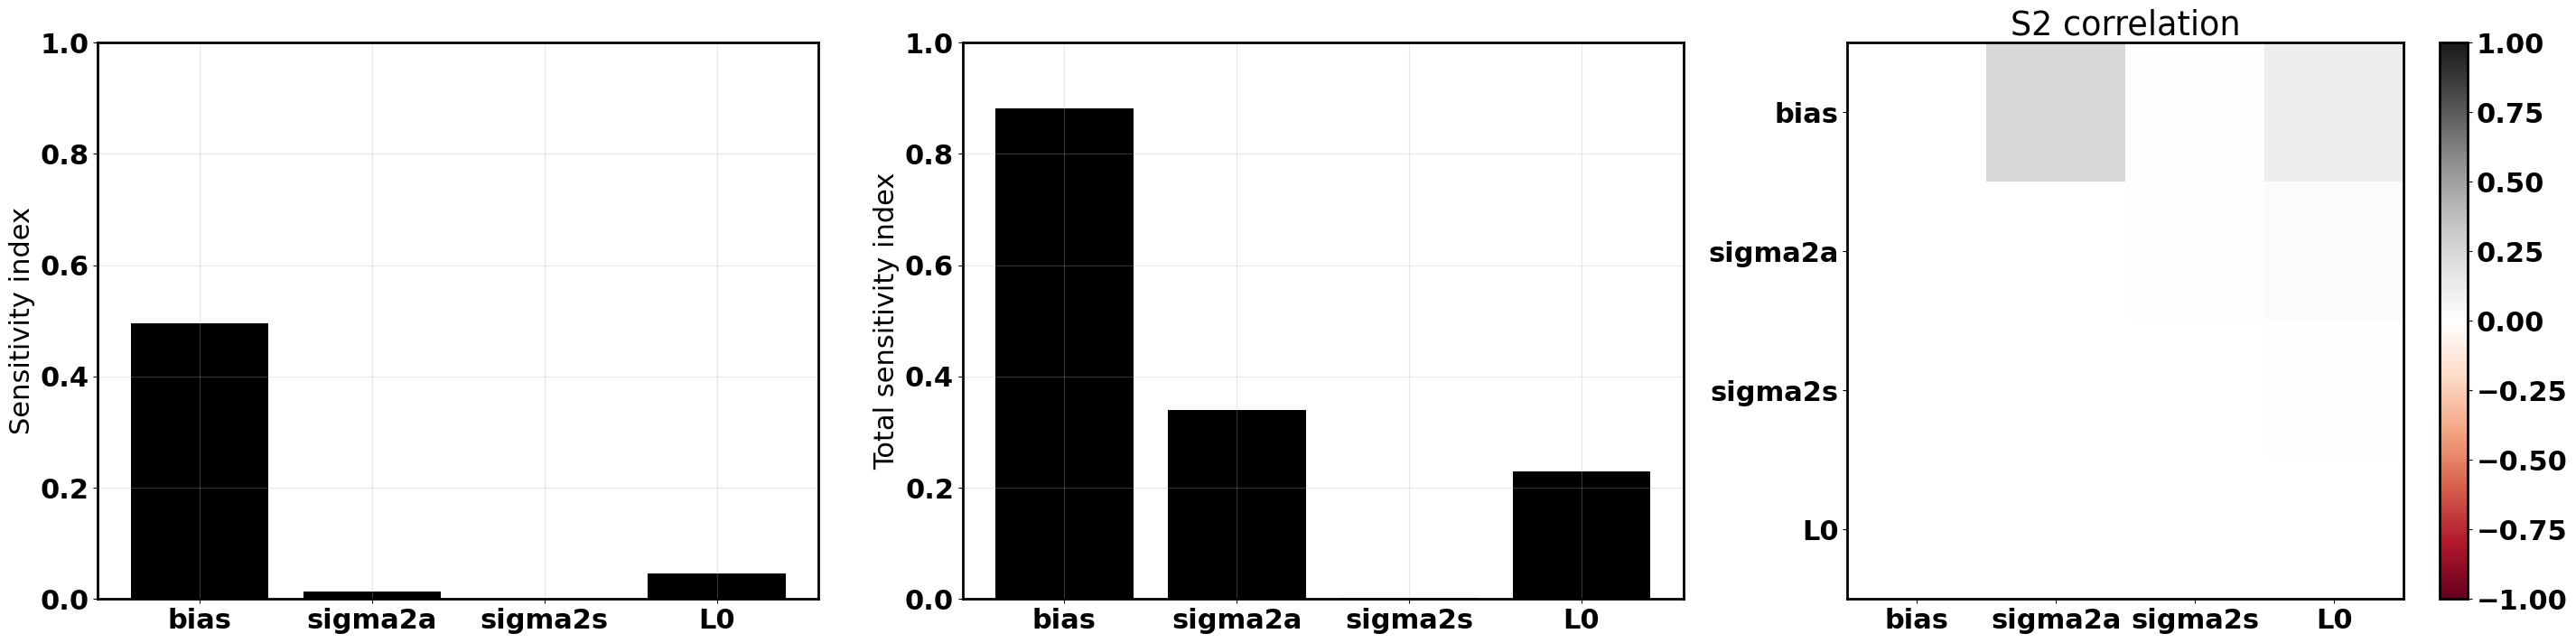

In [62]:
plot_Si(Si, problem)
# plot_corr(corr, Si, problem)

Bias has the highest first order sensitivity index (S1), which means the model output is most sensitive to changes in this variable when all others are held constant. However, the total-effect sensitivity index (ST) for bias is also quite high, indicating that interactions between bias and other variables are also important.

The S2 values indicate interaction effects between variables. For example, the value at S2[0][1] indicates the interaction effect between bias and sigma2a. Positive values mean that the interaction increases the output, while negative values mean that the interaction decreases the output. It's important to note that the values in S2 should be interpreted with caution if the S1 or ST values are close to 1, as this could mean that the model is nearly entirely dependent on a single parameter or a set of them.

The Spearman correlation matrix provides another way of examining the relationship between the parameters. A positive correlation implies that as one parameter increases, the other also increases. A negative correlation implies that as one parameter increases, the other decreases. The values range from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no correlation. Your Spearman correlation values are all quite close to 0, indicating that there is not a strong correlation between any two parameters.

In [ ]:
# define the problem
problem_2 = {
    'num_vars': 4,
    'names': ['bias', 'sigma2a', 'sigma2s', 'L0'],
    # 'bounds': [[-0.6, 0.2],
    #            [   0,  13],
    #            [   0,   5],
    #            [-1.2, 1.8]],
    'bounds': [[-2.5, 2.5],
               [   0,  77],
               [   0,  18],
               [ -11,  10]],
}

Si_2, corr_2 = compute_Si_corr(problem_2)

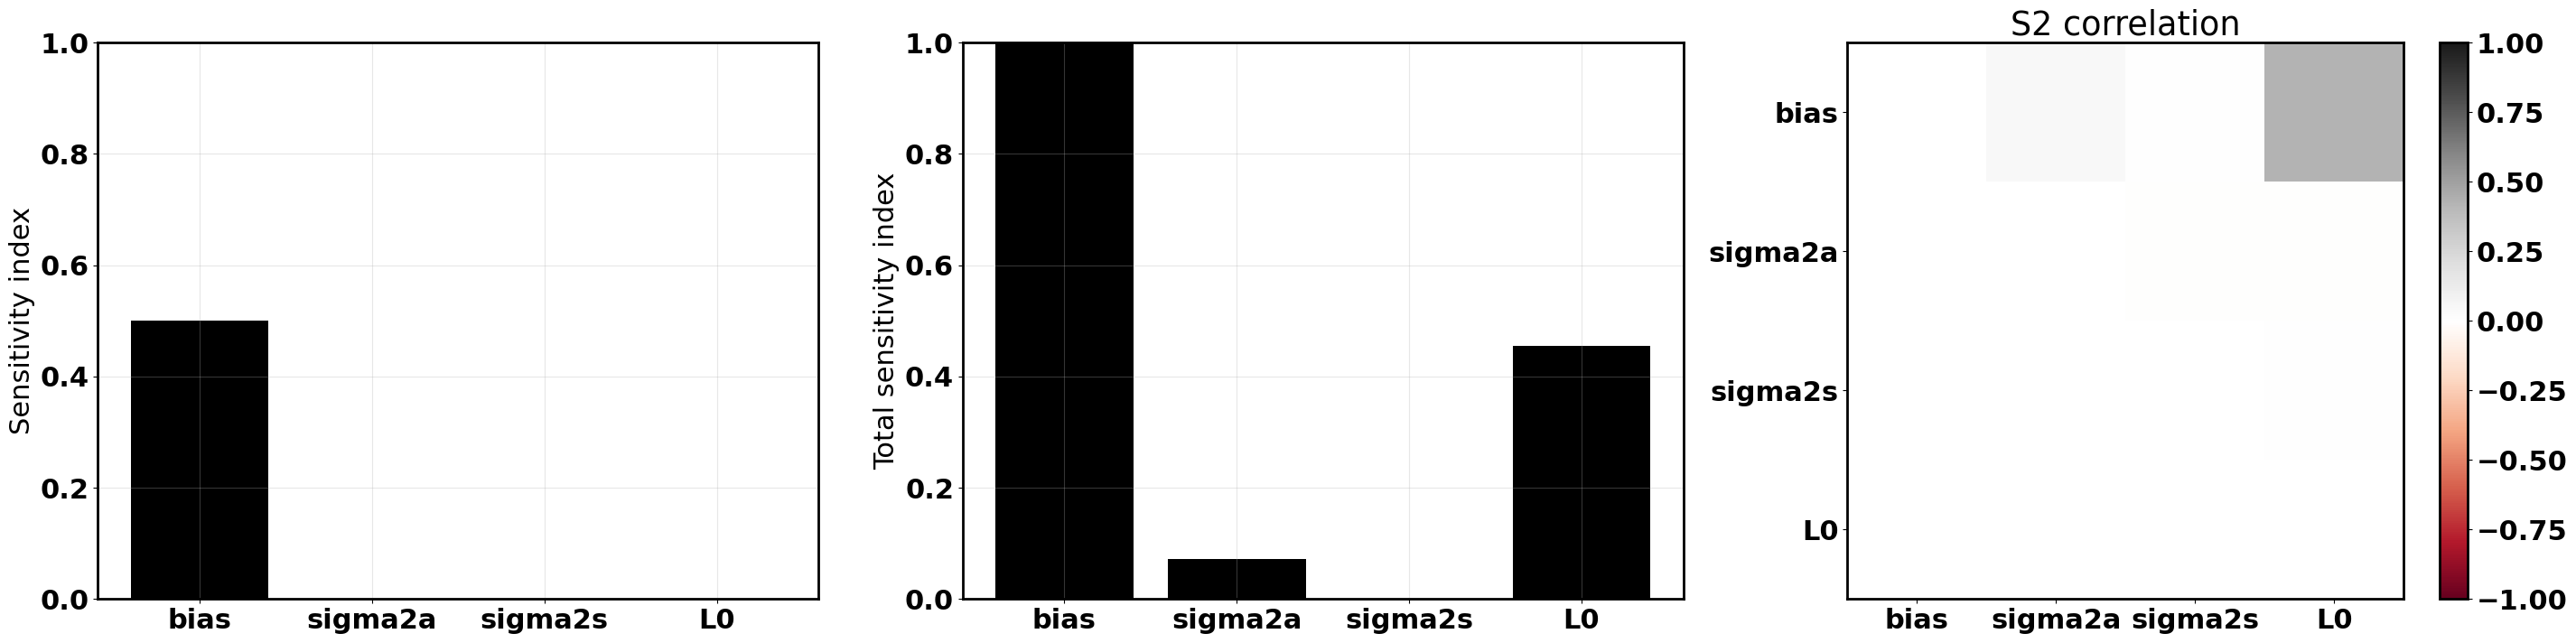

In [63]:
plot_Si(Si_2, problem_2)


--- generated seqC info ---
dur_list: [15]
MS_list: [0.8]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)


/tmp/ipykernel_2788680/154919084.py:14: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, nsample)


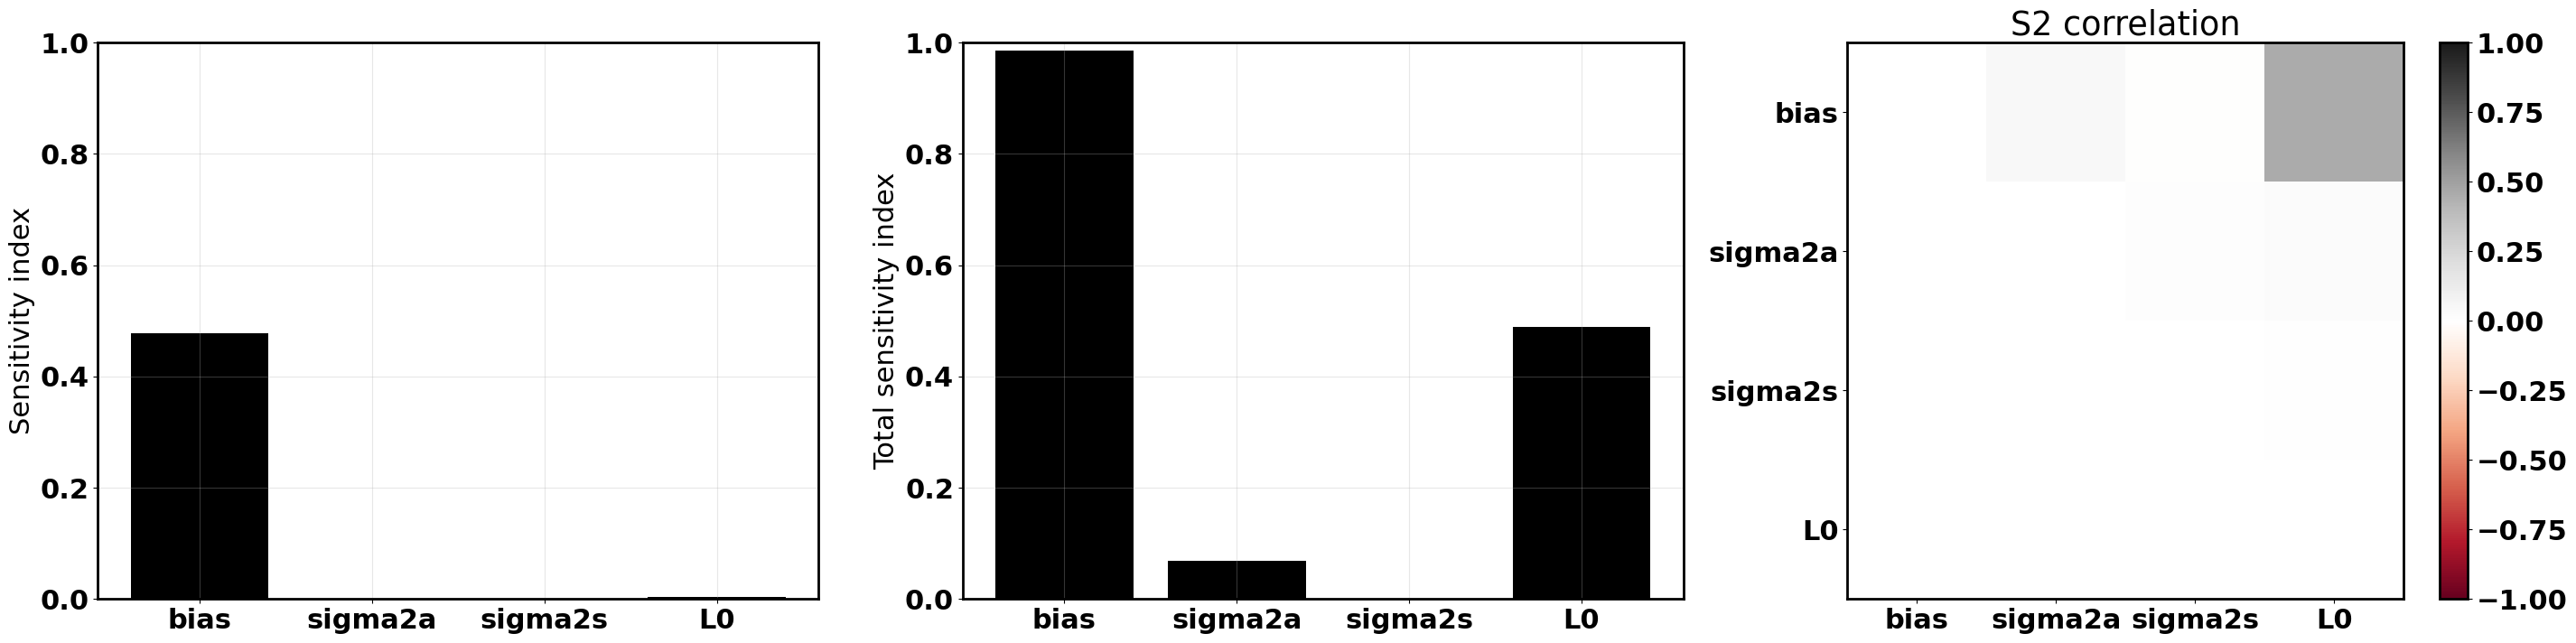

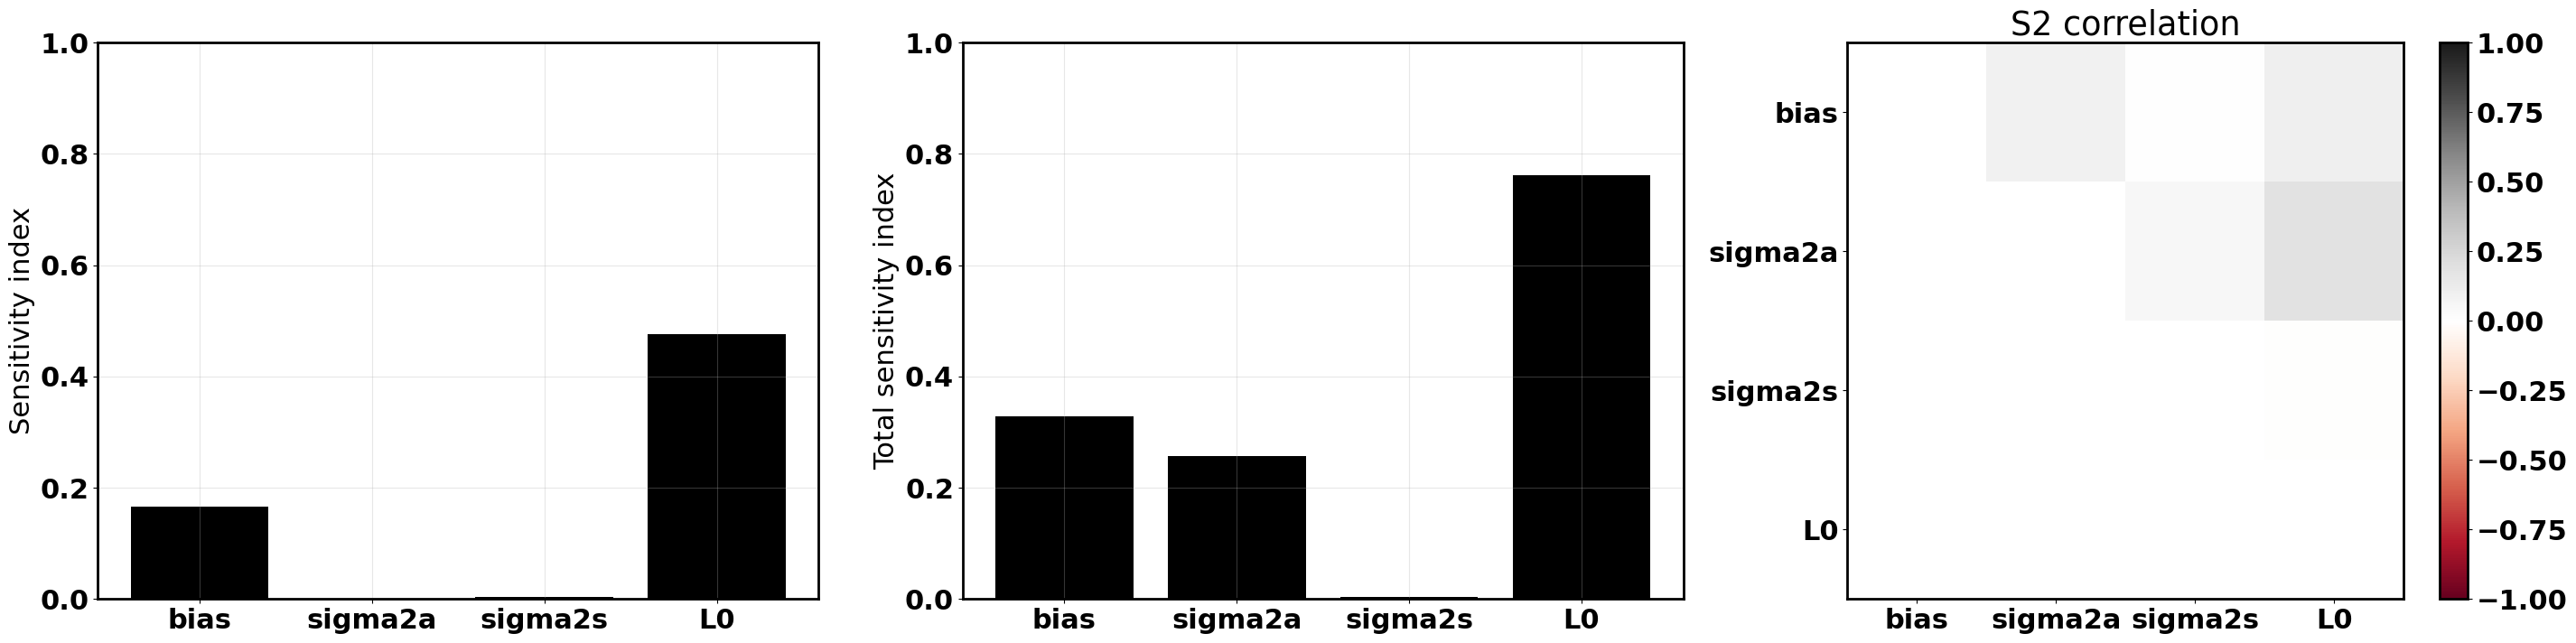

In [72]:
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[15],
    MS_list=[0.8],
    seqC_sample_per_MS=1,
)

problem = {
    'num_vars': 4,
    'names': ['bias', 'sigma2a', 'sigma2s', 'L0'],
    'bounds': [[-2.5, 2.5],
               [   0,  77],
               [   0,  18],
               [ -11,  10]],
}

Si, corr = compute_Si_corr(problem)
plot_Si(Si, problem)

problem_2 = {
    'num_vars': 4,
    'names': ['bias', 'sigma2a', 'sigma2s', 'L0'],
    'bounds': [[-0.6, 0.2],
               [   0,  13],
               [   0,   5],
               [-1.2, 1.8]],
}

Si_2, corr_2 = compute_Si_corr(problem_2)
plot_Si(Si_2, problem_2)


--- generated seqC info ---
dur_list: [15]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)


/tmp/ipykernel_2788680/154919084.py:14: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, nsample)


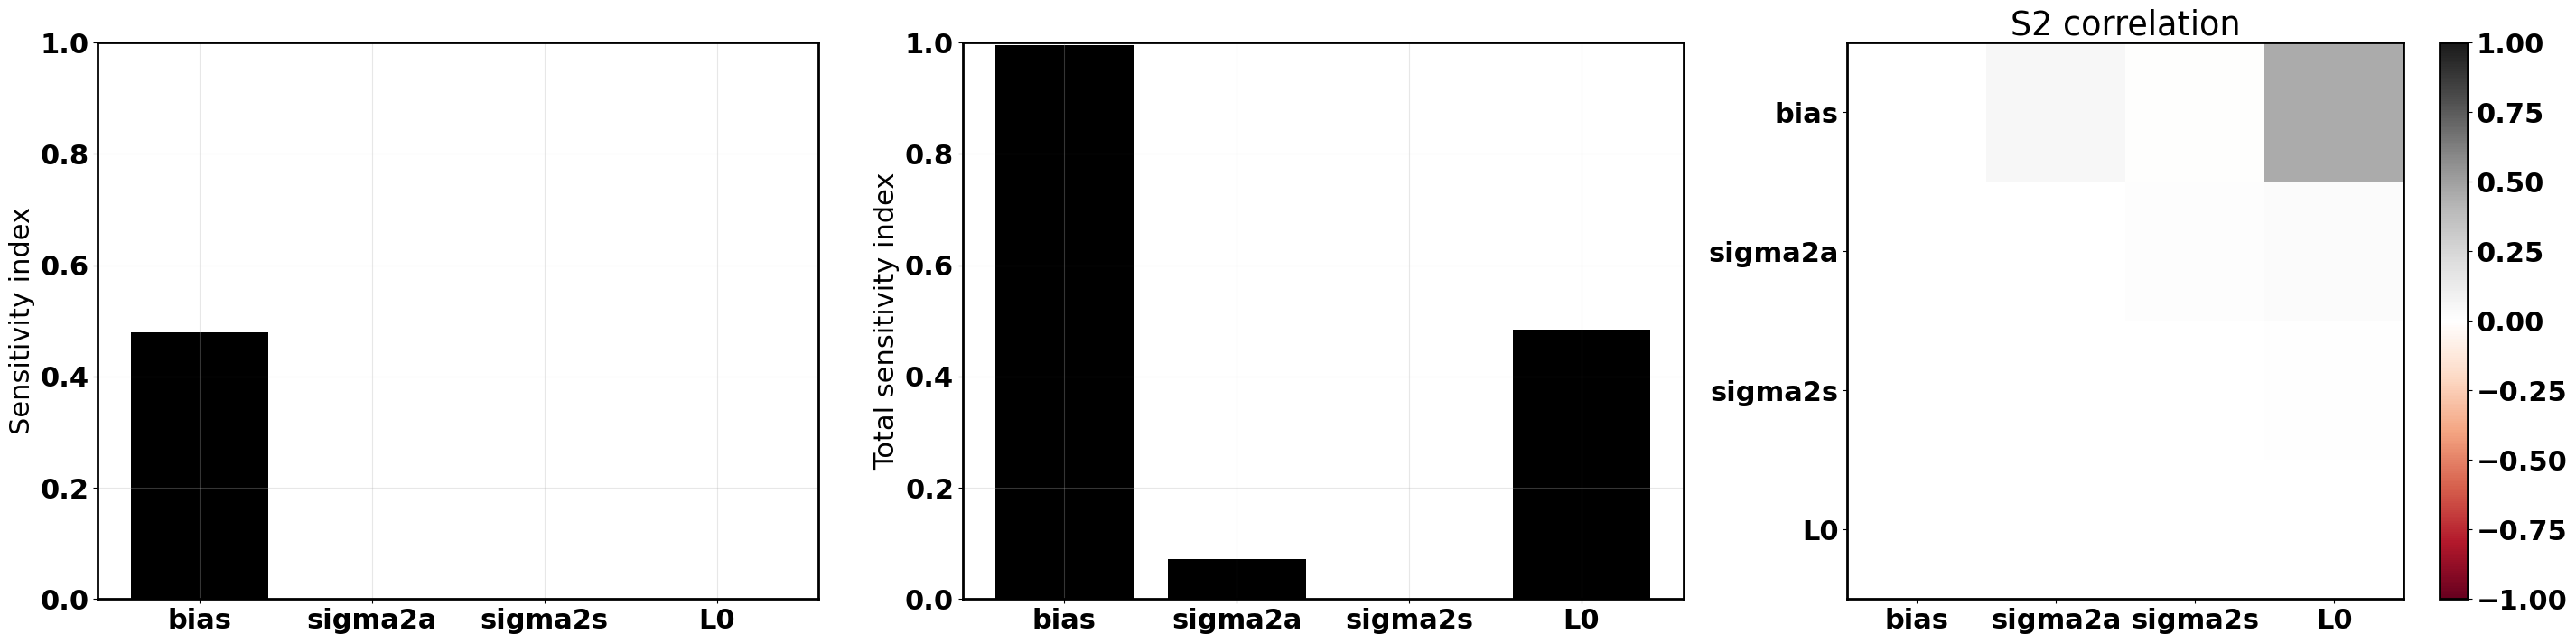

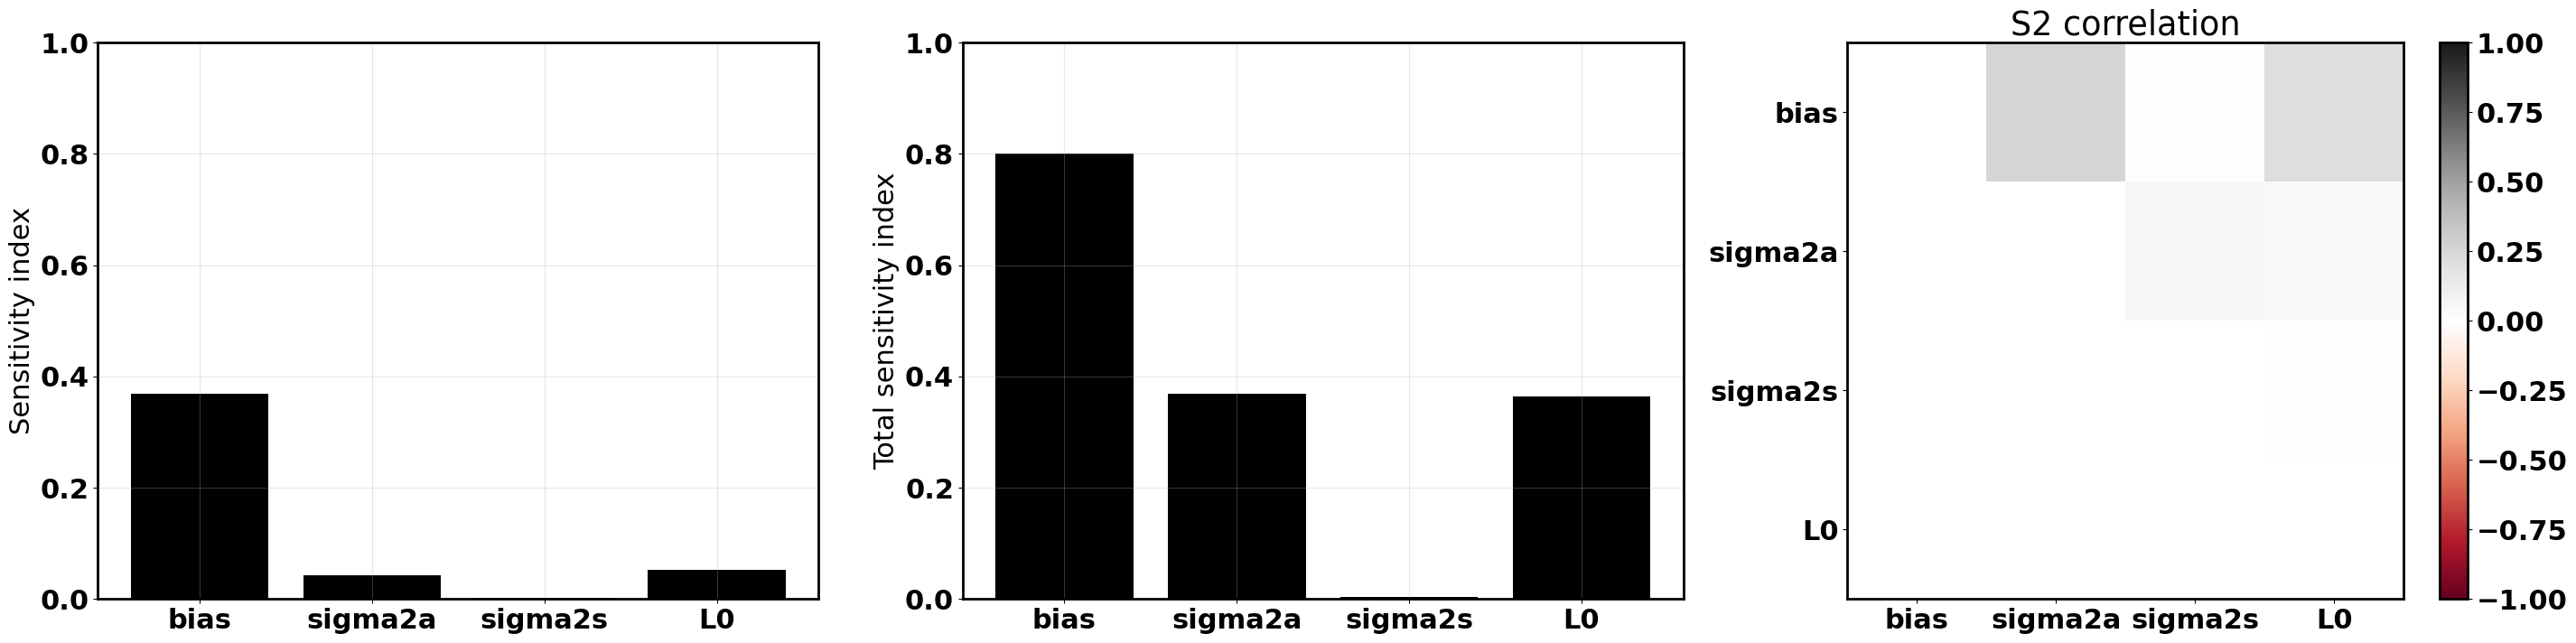

In [78]:
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[15],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)

problem = {
    'num_vars': 4,
    'names': ['bias', 'sigma2a', 'sigma2s', 'L0'],
    'bounds': [[-2.5, 2.5],
               [   0,  77],
               [   0,  18],
               [ -11,  10]],
}

Si, corr = compute_Si_corr(problem, nsample=2000)
plot_Si(Si, problem)

problem_2 = {
    'num_vars': 4,
    'names': ['bias', 'sigma2a', 'sigma2s', 'L0'],
    'bounds': [[-0.6, 0.2],
               [   0,  13],
               [   0,   5],
               [-1.2, 1.8]],
}

Si_2, corr_2 = compute_Si_corr(problem_2, nsample=2000)
plot_Si(Si_2, problem_2)


--- generated seqC info ---
dur_list: [15]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)


/tmp/ipykernel_2788680/154919084.py:14: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, nsample)


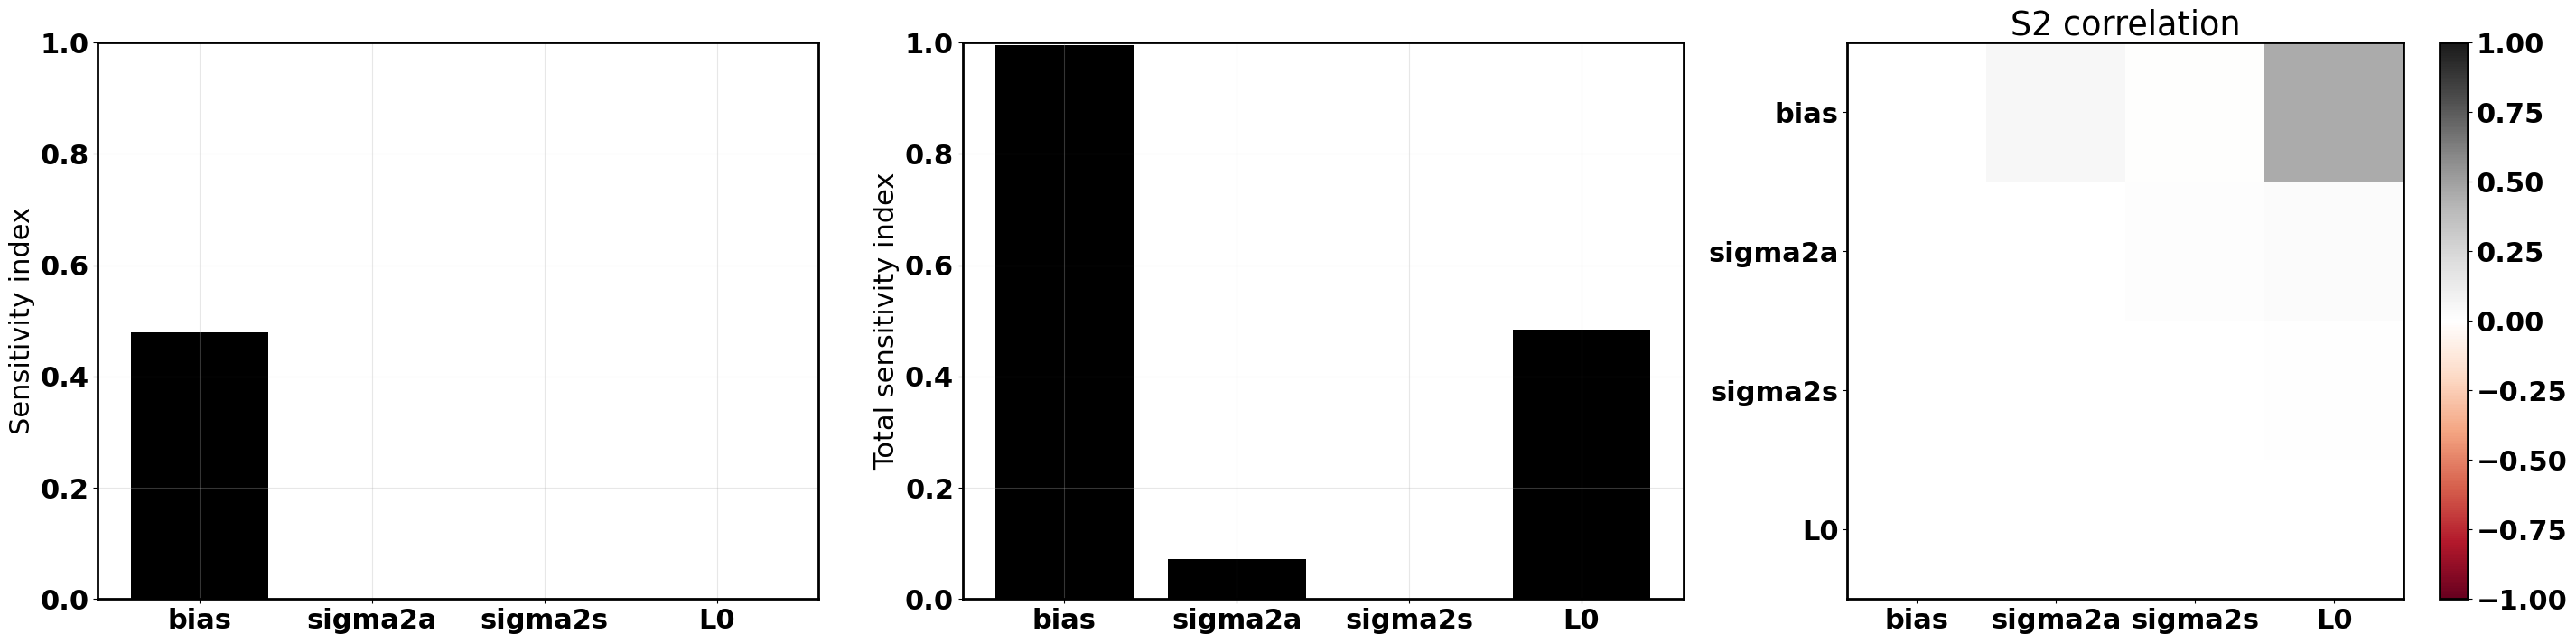

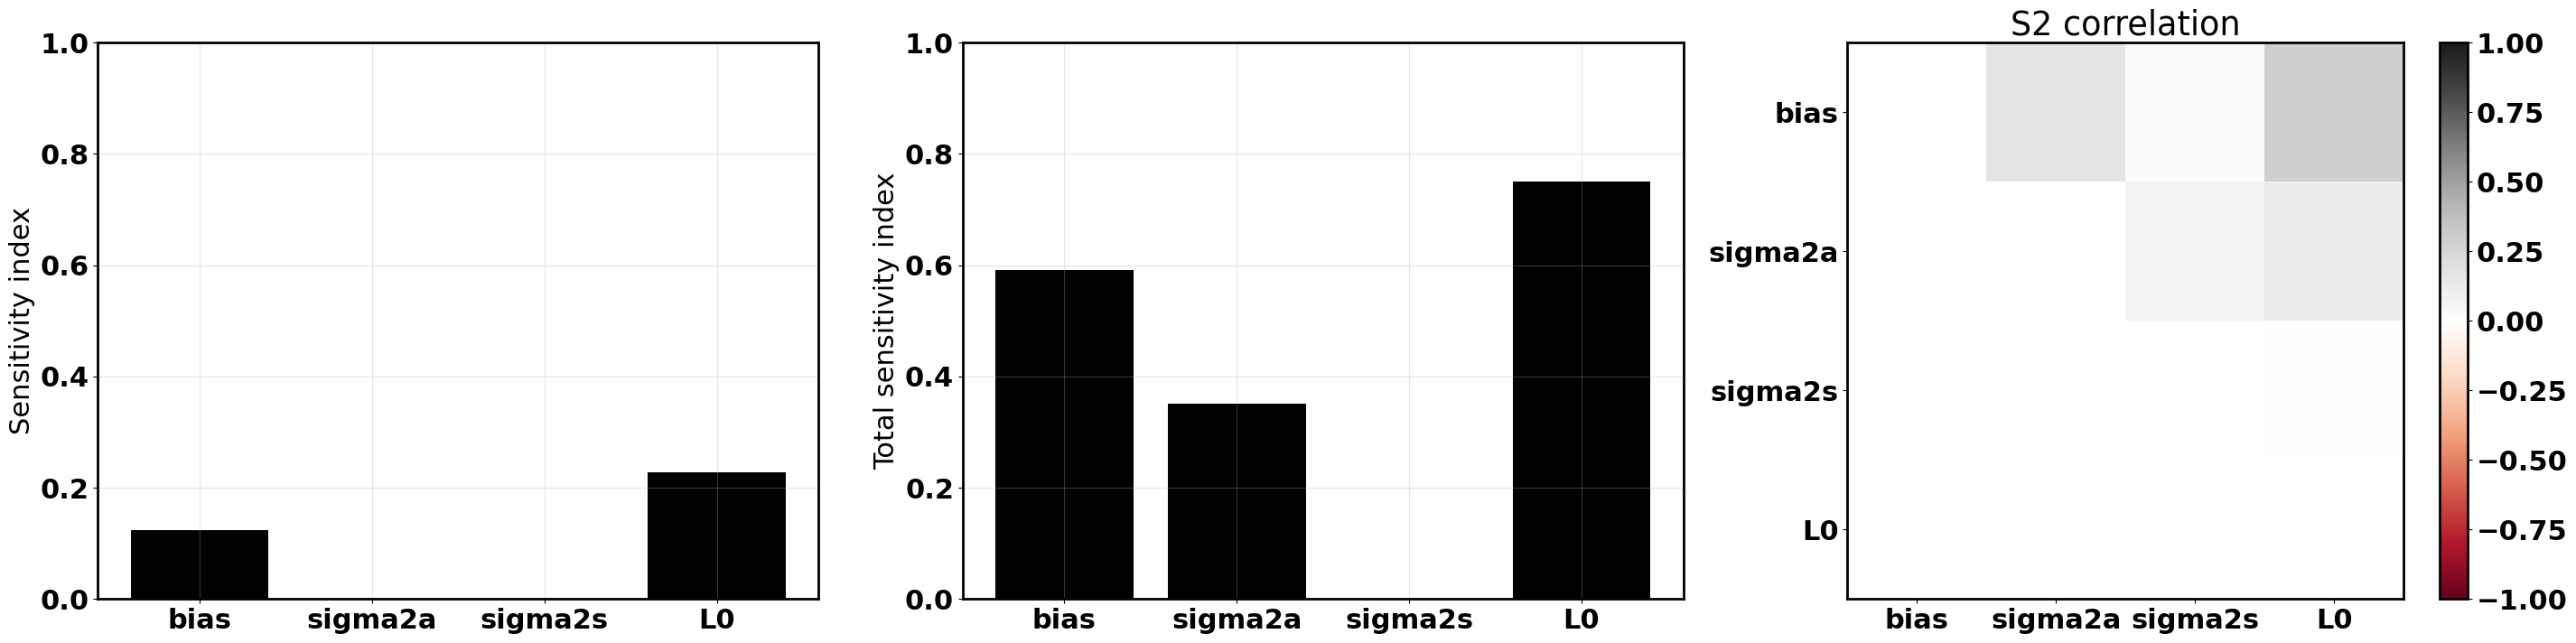

In [84]:
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[15],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)

problem = {
    'num_vars': 4,
    'names': ['bias', 'sigma2a', 'sigma2s', 'L0'],
    'bounds': [[-2.5, 2.5],
               [   0,  77],
               [   0,  18],
               [ -11,  10]],
}

Si, corr = compute_Si_corr(problem, nsample=2000)
plot_Si(Si, problem)

problem_2 = {
    'num_vars': 4,
    'names': ['bias', 'sigma2a', 'sigma2s', 'L0'],
    'bounds': [[-0.6, 0.2],
               [   0,  12.5],
               [   0,   1],
               [-1.2,   5]],
}

Si_2, corr_2 = compute_Si_corr(problem_2, nsample=2000)
plot_Si(Si_2, problem_2)

### build interface

In [8]:
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[9],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)
model_name = 'B-G-L0S-O-N-'
prior_min = [-2.5,   0,  0, -11]
prior_max = [ 2.5,  77, 18,  10]

prior_min = [-0.6,   0,  0, -1.2]
prior_max = [ 0.2,  13,  5,  1.8]

prior = get_boxUni_prior(prior_min, prior_max)
params = prior.sample((1,))[0].cpu().numpy()

bias_slider = widgets.FloatSlider(value=0, min=prior_min[0], max=prior_max[0], step=0.1, description='bias:')
sigma2a_slider = widgets.FloatSlider(value=0, min=prior_min[1], max=prior_max[1], step=0.1, description='sigma2a:')
sigma2s_slider = widgets.FloatSlider(value=0, min=prior_min[2], max=prior_max[2], step=0.1, description='sigma2s:')
L0_slider = widgets.FloatSlider(value=0, min=prior_min[3], max=prior_max[3], step=0.1, description='L0:')

def update_plot(bias, sigma2a, sigma2s, L0):
    plot_seqC_a_prior(model_name=model_name, prior_min=prior_min, prior_max=prior_max, params=[bias, sigma2a, sigma2s, L0])

interactive_plot = widgets.interactive(update_plot, bias=bias_slider, sigma2a=sigma2a_slider, sigma2s=sigma2s_slider, L0=L0_slider)
display(interactive_plot)



--- generated seqC info ---
dur_list: [9]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)


interactive(children=(FloatSlider(value=0.0, description='bias:', max=0.2, min=-0.6), FloatSlider(value=0.0, d…

### generate a movie

In [58]:
# seqC = seqC_generator().generate(
#     MS_list=[0.4],
#     sample_size=1,
#     single_dur=11
# )

# # generate prior parameters
# model_name = 'B-G-L0S-O-N-'
# prior_min = [-3.7,   0, 0,  0, -5]
# prior_max = [ 2.5,  71, 0, 18,  7]

# prior_step = [0.2, 1, 0, 1, 0.25]

params_collection = []
probRs_collection = []
a_collection = []

# for p_bias in tqdm(np.arange(prior_min[0], prior_max[0], prior_step[0])):
for p_bias in [0.5]:    
    # for p_sigma2a in np.arange(prior_min[1], prior_max[1], prior_step[1]):
    for p_sigma2a in [0.1]:
        for p_sigma2s in np.arange(prior_min[3], prior_max[3], prior_step[3]):
        # for p_sigma2s in [2]:
            # for p_L0 in np.arange(prior_min[4], prior_max[4], prior_step[4]):
            for p_L0 in [1]:
                params = [p_bias, p_sigma2a, 0, p_sigma2s, p_L0]
                model = DM_model(params=params, modelName=model_name)
                a, probR = model.simulate(seqC)
                params_collection.append(params)
                probRs_collection.append(probR)
                a_collection.append(a)

video_name = 'sigma2s.mp4'

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0


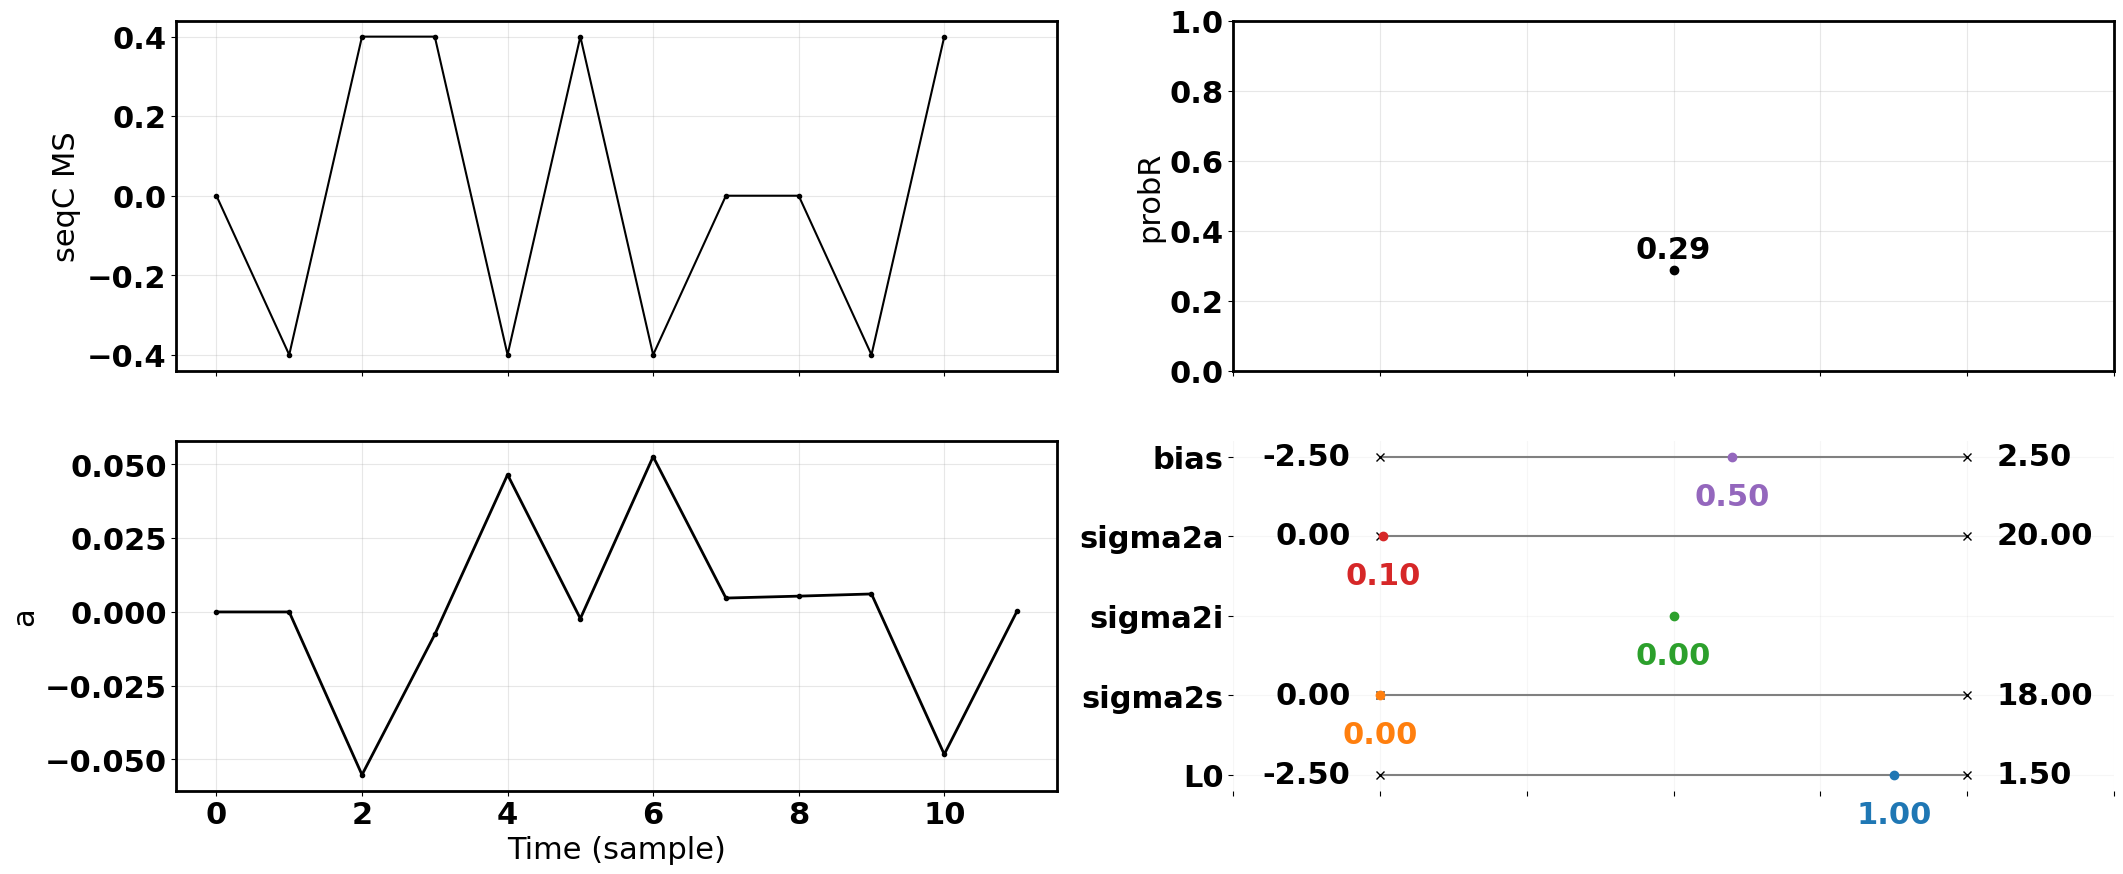

In [59]:
fig, axs = plt.subplots(2,2, sharex='col', figsize=(25, 10))

def update(frame):
    print(frame)
    ax = axs[0,0]
    ax.clear()
    ax.plot(seqC[0], '.-k')
    ax.grid(alpha=0.3)
    ax.set_ylabel('seqC MS')
    
    
    ax = axs[0,1]
    ax.clear()
    ax.plot(np.zeros(len(probRs_collection[:frame])), probRs_collection[:frame], '.', color='grey')
    ax.plot(0, probRs_collection[frame], 'o', color='k')
    if probR<0.5:
        ax.text(0, probRs_collection[frame]+0.1, f'{probRs_collection[frame]:.2f}', ha='center', va='top', color='k')
    else:
        ax.text(0, probRs_collection[frame]-0.1, f'{probRs_collection[frame]:.2f}', ha='center', va='bottom', color='k')
    ax.set_xlim(-1,1)
    ax.set_ylim(0,1)
    ax.grid(alpha=0.3)
    ax.set_ylabel('probR')
    
    # plot a mean trace
    ax = axs[1,0]
    ax.clear()
    ax = model.plot_a_mean_trace(ax, a_collection[frame], color='k')
    
    # plot parameter values
    ax = axs[1,1]
    ax.clear()
    params = params_collection[frame]
    plot_parameters(ax, params, prior_min, prior_max)
    

ani = animation.FuncAnimation(fig, update, frames=len(params_collection), interval=5)
# ani = animation.FuncAnimation(fig, update, frames=30, interval=5)
animation_location = Path('../../figures/prior_tuning')
ani.save(animation_location/video_name, fps=5)  

## run big simulations for prior analysis
所有可能的输入的组合 seqC </br>
all computations are run with the same seed </br>
so the same prior is used for all simulations</br>
code src file `./src/analysis/prior_range.py`</br>
code exe file `./src/analysis/run_prior_simulations_11.sh`  </br>
result files are saved in `/home/wehe/scratch/data/prior_sim`</br>
the number of simulations is huge, can even take days</br>
by parallelizing the simulations, we can reduce the time to ??? </br>

In [5]:
# read pickle file
dur_list = range(3, 15+1, 2)
ms_list = [0.2, 0.4, 0.8]

with open('../../data/seqC_combinatorial.pkl', 'rb') as f:
    output_seqs = pickle.load(f)
    
for dur in dur_list:
    print(f'dur_{dur:2} number of possible combinations: {len(output_seqs[f"dur_{dur:}"]):7}')

dur_ 3 number of possible combinations:       9
dur_ 5 number of possible combinations:      81
dur_ 7 number of possible combinations:     729
dur_ 9 number of possible combinations:    6561
dur_11 number of possible combinations:   59049
dur_13 number of possible combinations:  531441
dur_15 number of possible combinations: 4782969


after obtainning all simulated probR, corresponding theta, we can plot the marginal distribution of probR for each parameter </br>

In [6]:
data_dir = Path('../../data')

In [7]:
# read pickle file
with open(data_dir / 'seqC_combinatorial_probR_dict_dur_3.pkl', 'rb') as f:
    probR_dur_3 = pickle.load(f)[0]
with open(data_dir / 'seqC_combinatorial_theta_dict_dur_3.pkl', 'rb') as f:
    theta_dur_3 = pickle.load(f)[0]

with open(data_dir / 'seqC_combinatorial_probR_dict_dur_5.pkl', 'rb') as f:
    probR_dur_5 = pickle.load(f)[0]
with open(data_dir / 'seqC_combinatorial_theta_dict_dur_5.pkl', 'rb') as f:
    theta_dur_5 = pickle.load(f)[0]

In [8]:
probR_dur_3.shape, theta_dur_3.shape, probR_dur_5.shape, theta_dur_5.shape

((1, 3, 9, 500, 1), (1, 3, 9, 500, 4), (1, 3, 81, 500, 1), (1, 3, 81, 500, 4))

all the simulations share the same 500 parameter settings and in the same order

In [9]:
np.sum(theta_dur_3[0,0,2,:,:] - theta_dur_5[0,0,8,:,:])

0.0

theta shape: (500, 4)
num_theta: 4
prior_min: [-2.5, 0, 0, -11]
prior_max: [2.5, 77, 18, 10]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


sampled prior distributions


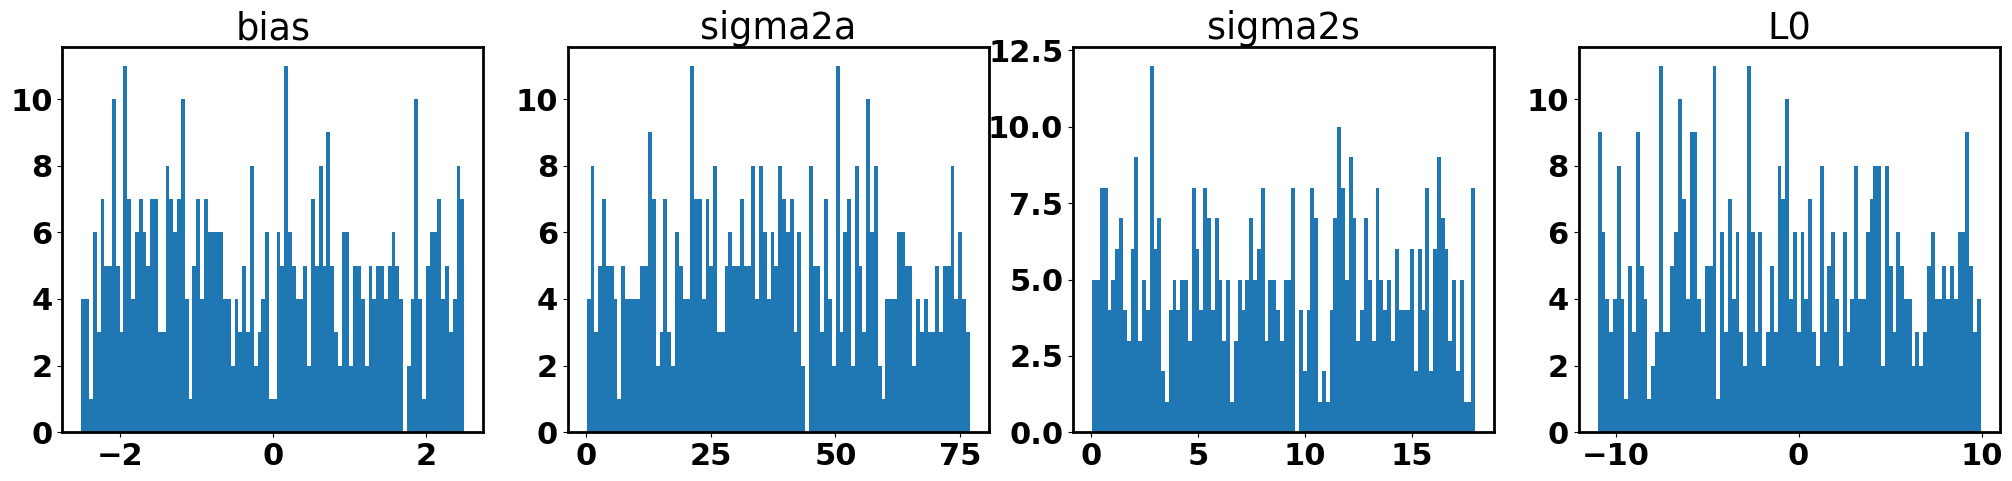

In [10]:
theta = theta_dur_3[0,0,0,:,:]
num_theta = theta.shape[1]
print(f'theta shape: {theta.shape}')
print(f'num_theta: {num_theta}')

prior_min = [-2.5,   0,  0, -11]
prior_max = [ 2.5,  77, 18,  10]
print(f'prior_min: {prior_min}')
print(f'prior_max: {prior_max}')

prior_labels = ['bias', 'sigma2a', 'sigma2s', 'L0']
# plot theta distributions
fig, ax = plt.subplots(1, num_theta, figsize=(25, 5))
for i in range(num_theta):
    ax[i].hist(theta[:,i], bins=100)
    ax[i].set_title(prior_labels[i])
print('sampled prior distributions')

In [59]:
num_sample = 3000
from sbi import utils
prior = utils.torchutils.BoxUniform(
        low     = np.array(prior_min, dtype=np.float32),
        high    = np.array(prior_max, dtype=np.float32),
    )
theta = prior.sample((num_sample,))

Text(0.5, 1.0, '3000 prior samples')

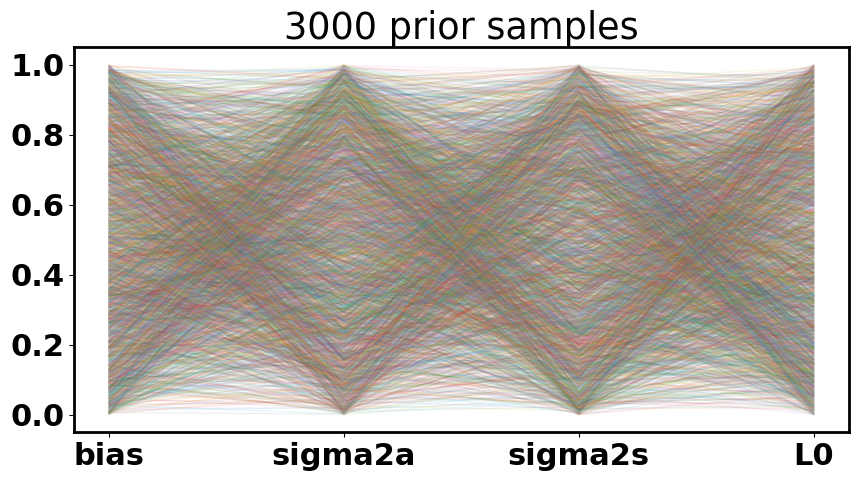

In [60]:
theta_norm = np.zeros(theta.shape)
for i in range(4):
    theta_norm[:,i] = (theta[:,i]-prior_min[i])/(prior_max[i]-prior_min[i])
    
plt.figure(figsize=(10,5))
_ = plt.plot(theta_norm.T, alpha=0.1, lw=1)
plt.xticks(range(4), prior_labels)
plt.title(f'{num_sample} prior samples')
# plt.grid(alpha=0.3)

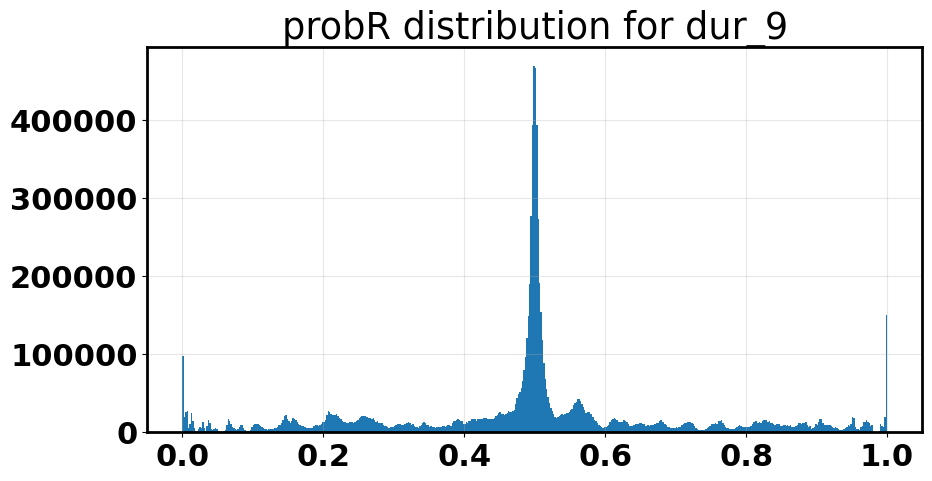

In [63]:
dur = 9
with open(data_dir / f'seqC_combinatorial_probR_dict_dur_{dur}.pkl', 'rb') as f:
    probR = pickle.load(f)[0]

plt.figure(figsize=(10,5))
_ = plt.hist(probR.reshape(-1), bins=500)
plt.title(f'probR distribution for dur_{dur}')
plt.grid(alpha=0.3)

plot the marginal distribution of probR for each parameter </br>

/home/wehe/anaconda3/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


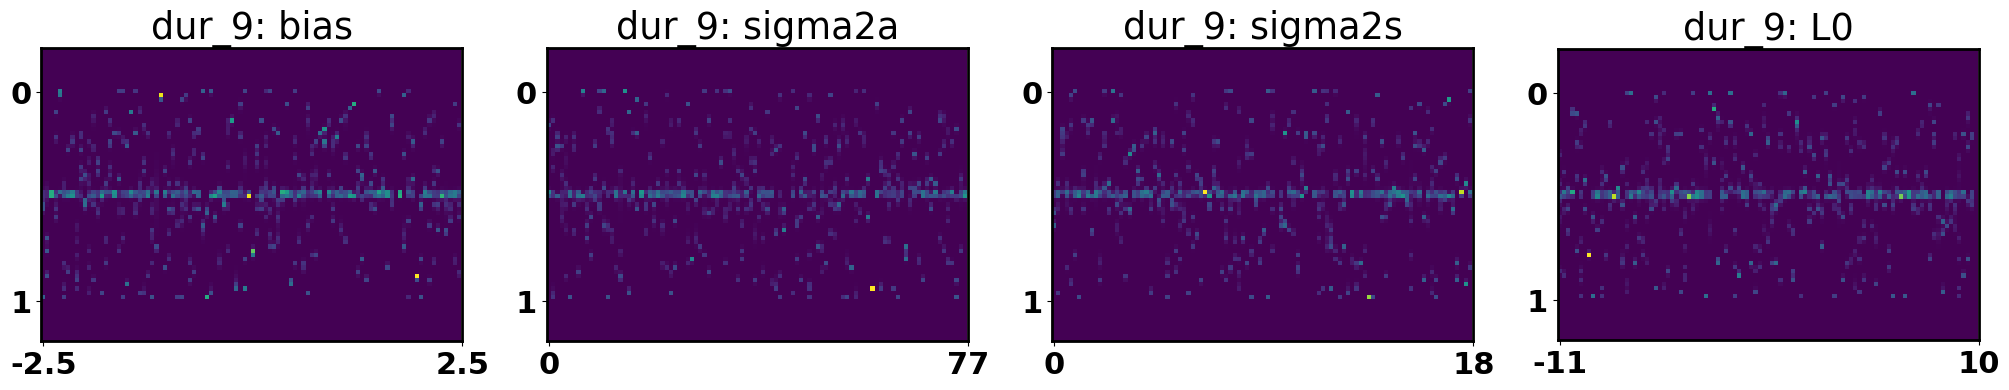

In [64]:
fig, axs = plt.subplots(1,4, figsize=(25, 10))
for k, theta_col_idx in enumerate([0, 1, 2, 3]):

    theta_one_col = theta[:,theta_col_idx]
    theta_range = [prior_min[theta_col_idx], prior_max[theta_col_idx]]
    theta_step = (theta_range[1] - theta_range[0]) / 100
    theta_bin = np.arange(theta_range[0], theta_range[1]+theta_step, theta_step)

    histograms = []
    for i in range(len(theta_bin)-1):
        theta_bin_range = [theta_bin[i], theta_bin[i+1]]
        theta_row_idx_current_bin = np.where((theta_one_col>=theta_bin_range[0]) & (theta_one_col<theta_bin_range[1]))[0]
        probR_masked = probR[:,:,:, theta_row_idx_current_bin,:].reshape(-1)
        histogram, _ = np.histogram(probR_masked, bins=50, range=(0, 1))
        histograms.append(histogram)
    histograms = np.array(histograms)
    histograms = histograms / histograms.sum(axis=1, keepdims=True)
    # avoid the case where the histogram is all zeros
    histograms[np.isnan(histograms)] = 0
    
    offset = 10
    # expand histogram with two more columns with zeros
    histograms = np.concatenate([np.zeros((histograms.shape[0], offset)), histograms, np.zeros((histograms.shape[0], offset))], axis=1)
    
    # ax = axs[k//2][k%2]
    ax = axs[k]
    ax.imshow(histograms.T)
    
    xticklabels=[prior_min[theta_col_idx], prior_max[theta_col_idx]]
    ax.set_xticks([0, len(theta_bin)-1])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([offset, offset+50])
    ax.set_yticklabels([0, 1])
    ax.set_title(f'dur_{dur}: {prior_labels[theta_col_idx]}')

TODO Fix the bias to 0, sigma2a to 0.2 for the 

One concern is that the probR result distribution is not good for training the neural network. </br>
Which can lead to a **overfitting** of the network where the network would produce a distribution that is lead to a 0.5/0/1 probR. </br>

try linear regression on the probR result </br>

## analysis with dur 11/13/15 on uzh server

In [38]:
dur = 15
data_dir = Path('/home/wehe/scratch/data/prior_sim/')
files = os.listdir(data_dir)

dur_probR_idx = np.where(np.array([float(f.split("dur_")[1].split('_')[0]) for f in files ])==dur)[0]
dur_probR = [files[idx] for idx in dur_probR_idx]
dur_probR.sort(key=lambda x: int(x.split('_part')[-1].split('.')[0]))
dur_probR = [f for f in dur_probR if f.startswith('seqC_combinatorial_probR')]

100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


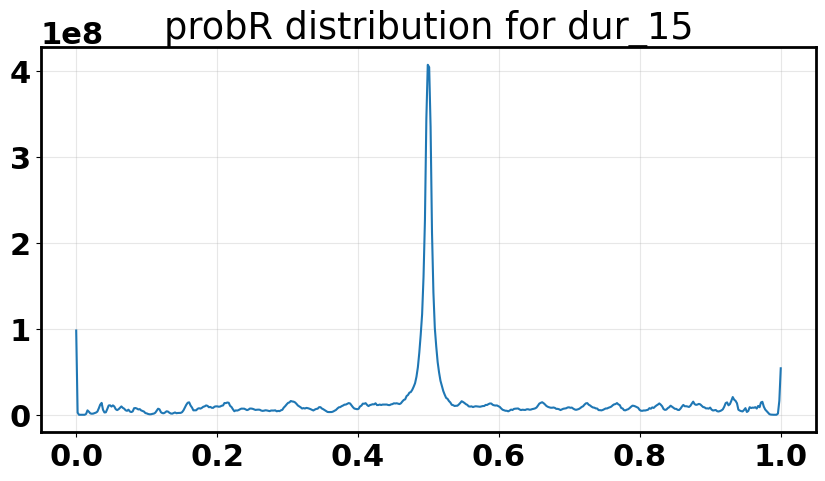

In [39]:
hist_dur = np.zeros(500, dtype=int)
for probRs in tqdm(dur_probR):
    with open(data_dir / probRs, 'rb') as f:
        probR_dur = pickle.load(f)[0]
        probR_dur = probR_dur.reshape(-1)
        hist, bins = np.histogram(probR_dur, bins=500, range=(0, 1))
        hist_dur += hist

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,1,500), hist_dur)
plt.title(f'probR distribution for dur_{dur}')
plt.grid(alpha=0.3)

In [9]:
with open('../../data/seqC_combinatorial.pkl', 'rb') as f:
    output_seqs = pickle.load(f)

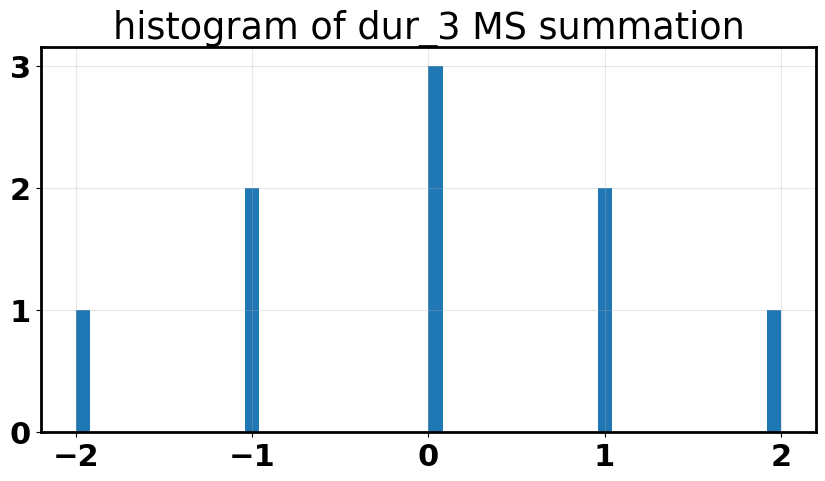

In [36]:
dur = 3
seq_sum = np.sum(output_seqs[f'dur_{dur}'], axis=1)
plt.figure(figsize=(10,5))
_ = plt.hist(seq_sum, bins=50)
plt.title(f'histogram of dur_{dur} MS summation')
plt.grid(alpha=0.3)